Creating small binary classification dataset...
Creating medium binary classification dataset...
Loading breast cancer dataset...
Loading digits dataset...
Creating regression dataset...

COMPREHENSIVE K-MEANS GRADIENT OPTIMIZATION EVALUATION

DATASET: Small Binary (800×10)
K-selection method: sqrt
K-means optimizer: k=9/97 (9.3% compression)
Training on 640 samples, testing on 160 samples
Network: 10→8→1 (97 parameters)
K-means using k=9 representatives (9.3% compression)
Epoch   0 | Baseline: 1.0431 | K-means: 1.0431 | Savings: 0.0% | Speedup: 1.01x
Epoch  20 | Baseline: 0.8636 | K-means: 0.8636 | Savings: 90.7% | Speedup: 10.17x
Epoch  40 | Baseline: 0.7242 | K-means: 0.7242 | Savings: 90.7% | Speedup: 1.14x
Epoch  60 | Baseline: 0.6170 | K-means: 0.6171 | Savings: 90.7% | Speedup: 10.14x
Epoch  79 | Baseline: 0.5385 | K-means: 0.5388 | Savings: 90.7% | Speedup: 10.32x

DATASET: Small Binary (800×10)
K-selection method: log
K-means optimizer: k=13/97 (13.4% compression)
Training on 

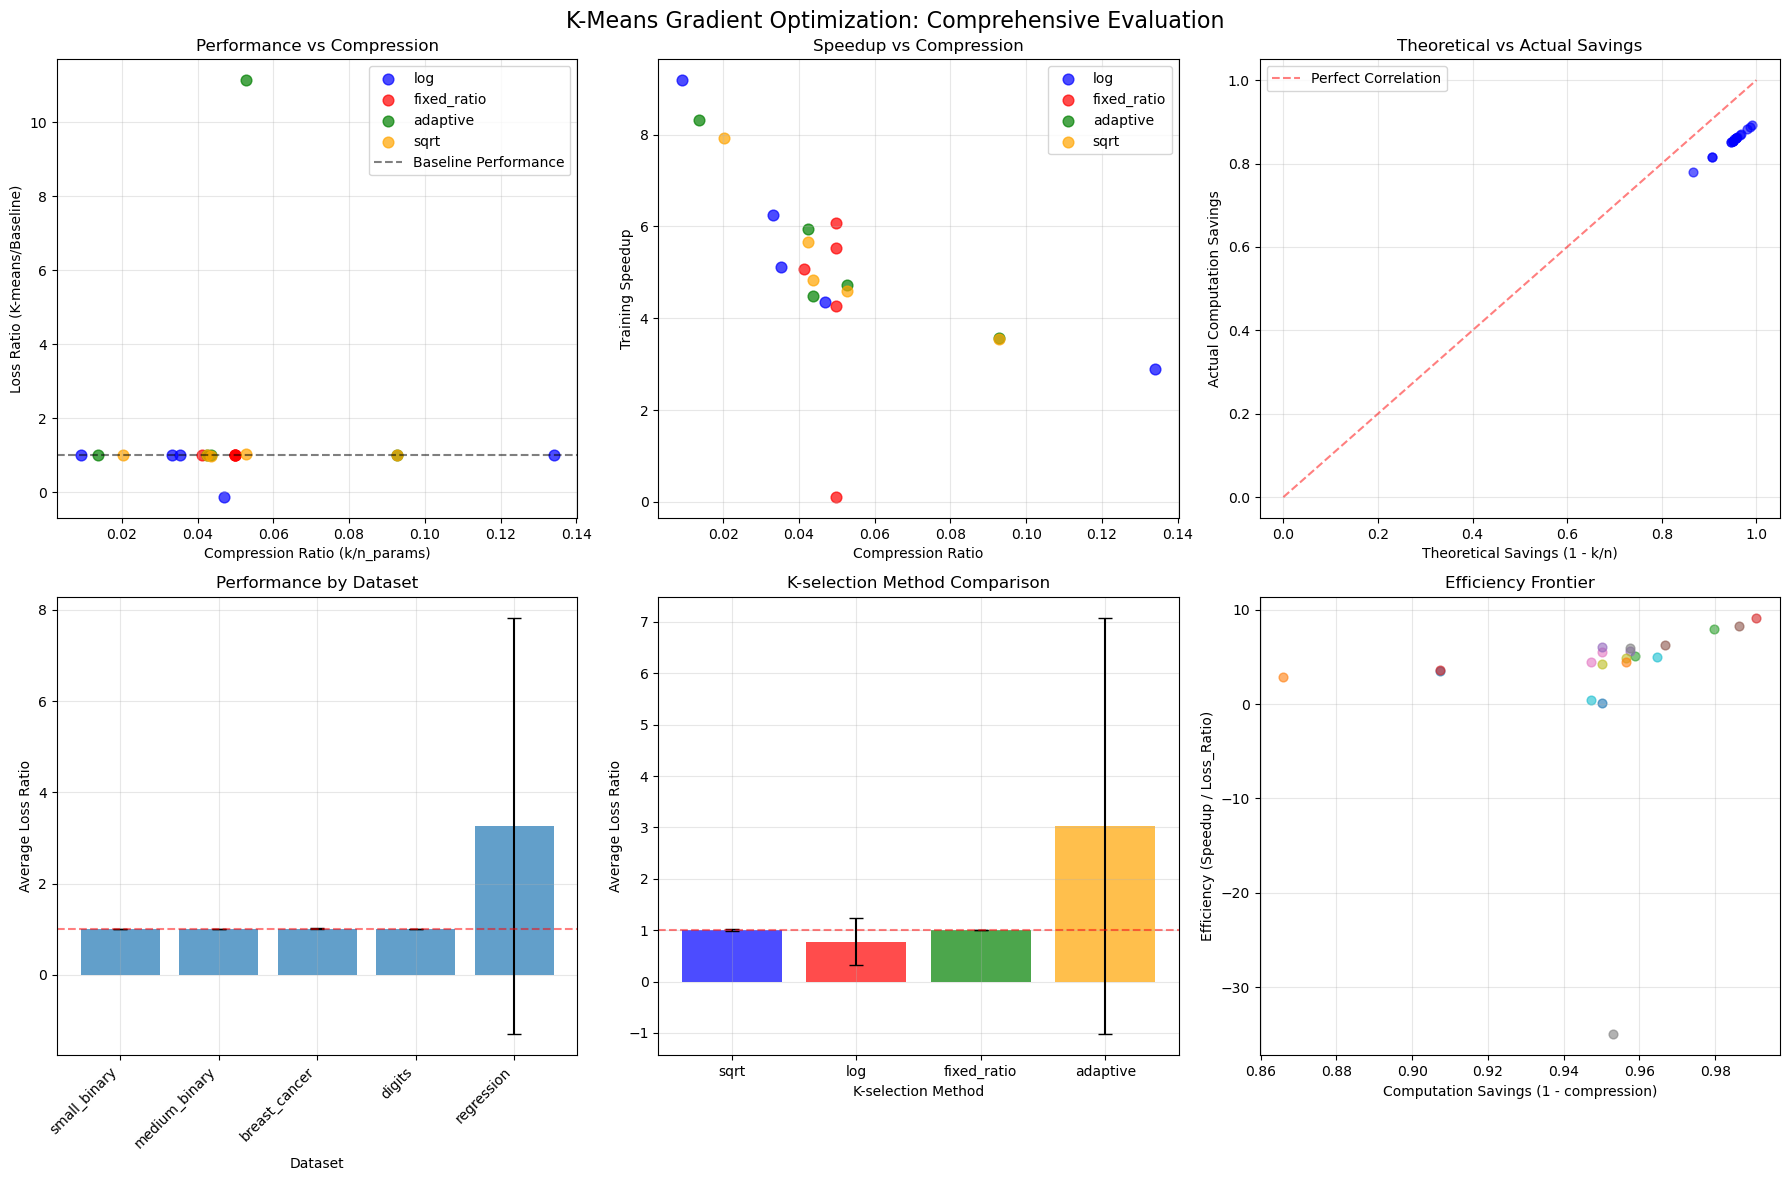


COMPREHENSIVE EVALUATION SUMMARY

BEST PERFORMANCE (lowest loss degradation):
  Dataset: Regression (1000×15)
  K-method: log
  Loss ratio: -0.1246
  Compression: 4.7%
  Speedup: 4.36x

BEST SPEEDUP:
  Dataset: Digits (1797×64→10)
  K-method: log
  Speedup: 9.18x
  Loss ratio: 1.0003
  Compression: 0.9%

BEST EFFICIENCY (speedup / loss_ratio):
  Dataset: Digits (1797×64→10)
  K-method: log
  Efficiency: 9.18
  Loss ratio: 1.0003
  Speedup: 9.18x

K-SELECTION METHOD ANALYSIS:
  log         : Loss=0.779, Speedup=5.56x, Compression=5.2%
  fixed_ratio : Loss=1.000, Speedup=4.21x, Compression=4.8%
  adaptive    : Loss=3.028, Speedup=5.41x, Compression=4.9%
  sqrt        : Loss=1.007, Speedup=5.31x, Compression=5.0%


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, load_digits, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import deque
import time
import warnings
warnings.filterwarnings('ignore')

class KMeansGradientOptimizer:
    def __init__(self, n_params, k=None, k_selection_method='sqrt', 
                 window_size=15, min_confidence=0.6, update_freq=10):
        """
        K-means based gradient optimizer with intelligent k selection
        
        Args:
            n_params: Total number of parameters
            k: Number of representatives (if None, use k_selection_method)
            k_selection_method: How to choose k ('sqrt', 'log', 'fixed_ratio', 'elbow')
            window_size: Gradient history size
            min_confidence: Minimum R² for predictions
            update_freq: How often to update clusters
        """
        self.n_params = n_params
        self.window_size = window_size
        self.min_confidence = min_confidence
        self.update_freq = update_freq
        self.k_selection_method = k_selection_method
        
        # Determine k intelligently
        self.k = self._select_k(n_params, k, k_selection_method)
        self.compression_ratio = self.k / n_params
        
        # Storage
        self.gradient_history = deque(maxlen=window_size)
        self.representatives = None
        self.prediction_models = {}
        self.steps_since_update = 0
        
        # Statistics
        self.stats = {
            'computed_gradients': 0,
            'predicted_gradients': 0,
            'computation_times': [],
            'cluster_updates': 0
        }
        
        print(f"K-means optimizer: k={self.k}/{n_params} ({self.compression_ratio:.1%} compression)")
    
    def _select_k(self, n_params, k, method):
        """Intelligently select number of representatives"""
        if k is not None:
            return min(k, n_params)
        
        if method == 'sqrt':
            # Square root heuristic - common in clustering
            return max(1, int(np.sqrt(n_params)))
        
        elif method == 'log':
            # Logarithmic scaling - good for very large parameter spaces
            return max(1, int(np.log2(n_params) * 2))
        
        elif method == 'fixed_ratio':
            # Fixed 5% of parameters
            return max(1, int(0.05 * n_params))
        
        elif method == 'adaptive':
            # Adaptive based on parameter count
            if n_params < 100:
                return max(1, n_params // 10)  # 10% for small networks
            elif n_params < 1000:
                return max(1, int(np.sqrt(n_params)))  # sqrt for medium
            else:
                return max(1, int(np.log2(n_params) * 3))  # log for large
        
        else:
            return max(1, int(np.sqrt(n_params)))  # Default to sqrt
    
    def update_representatives(self):
        """Update representatives using k-means clustering"""
        if len(self.gradient_history) < 3:
            self.representatives = np.random.choice(self.n_params, self.k, replace=False)
            return
        
        # Get gradient matrix (time_steps, n_params)
        gradient_matrix = np.array(list(self.gradient_history))
        
        # Transpose to get parameter trajectories (n_params, time_steps)
        param_trajectories = gradient_matrix.T
        
        # K-means clustering
        try:
            kmeans = KMeans(n_clusters=self.k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(param_trajectories)
            
            # Select representative from each cluster (closest to centroid)
            representatives = []
            for cluster_id in range(self.k):
                cluster_members = np.where(cluster_labels == cluster_id)[0]
                if len(cluster_members) > 0:
                    # Find member closest to cluster center
                    cluster_center = kmeans.cluster_centers_[cluster_id]
                    distances = np.linalg.norm(param_trajectories[cluster_members] - cluster_center, axis=1)
                    best_member = cluster_members[np.argmin(distances)]
                    representatives.append(best_member)
            
            self.representatives = np.array(representatives[:self.k])
            
        except Exception as e:
            # Fallback to random selection
            self.representatives = np.random.choice(self.n_params, self.k, replace=False)
        
        # Update prediction models
        self.update_prediction_models()
        self.stats['cluster_updates'] += 1
    
    def update_prediction_models(self):
        """Learn prediction models for non-representative parameters"""
        self.prediction_models = {}
        
        if len(self.gradient_history) < 5 or self.representatives is None:
            return
        
        gradient_matrix = np.array(list(self.gradient_history))
        rep_set = set(self.representatives)
        
        for param_idx in range(self.n_params):
            if param_idx not in rep_set:
                param_grads = gradient_matrix[:, param_idx]
                rep_grads = gradient_matrix[:, self.representatives]
                
                try:
                    # Multiple linear regression
                    A = np.hstack([rep_grads, np.ones((rep_grads.shape[0], 1))])
                    coeffs = np.linalg.lstsq(A, param_grads, rcond=None)[0]
                    weights = coeffs[:-1]
                    bias = coeffs[-1]
                    
                    # Compute R²
                    predicted = rep_grads @ weights + bias
                    ss_res = np.sum((param_grads - predicted) ** 2)
                    ss_tot = np.sum((param_grads - np.mean(param_grads)) ** 2)
                    r_squared = 1 - (ss_res / (ss_tot + 1e-10))
                    
                    self.prediction_models[param_idx] = {
                        'weights': weights,
                        'bias': bias,
                        'confidence': max(0, r_squared)
                    }
                
                except:
                    pass
    
    def compute_efficient_gradient(self, params, gradient_func):
        """Compute gradients using k-means clustering"""
        start_time = time.time()
        
        # Update representatives periodically
        self.steps_since_update += 1
        if self.steps_since_update >= self.update_freq or self.representatives is None:
            self.update_representatives()
            self.steps_since_update = 0
        
        gradient = np.zeros(self.n_params)
        computed_count = 0
        predicted_count = 0
        
        # Compute gradients for representatives
        if self.representatives is not None:
            for rep_idx in self.representatives:
                gradient[rep_idx] = gradient_func(params, rep_idx)
                computed_count += 1
        
        # Predict gradients for non-representatives
        rep_set = set(self.representatives) if self.representatives is not None else set()
        
        for param_idx in range(self.n_params):
            if param_idx not in rep_set:
                if (param_idx in self.prediction_models and 
                    self.prediction_models[param_idx]['confidence'] >= self.min_confidence):
                    
                    model = self.prediction_models[param_idx]
                    rep_grads = gradient[self.representatives]
                    predicted_grad = np.dot(model['weights'], rep_grads) + model['bias']
                    gradient[param_idx] = predicted_grad
                    predicted_count += 1
                    
                else:
                    # Fallback: compute actual gradient
                    gradient[param_idx] = gradient_func(params, param_idx)
                    computed_count += 1
        
        # Store results
        self.gradient_history.append(gradient.copy())
        self.stats['computed_gradients'] += computed_count
        self.stats['predicted_gradients'] += predicted_count
        
        computation_time = time.time() - start_time
        self.stats['computation_times'].append(computation_time)
        
        return gradient, computed_count, predicted_count

class SimpleNeuralNetwork:
    def __init__(self, n_features, n_hidden, n_outputs, activation='tanh'):
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.activation = activation
        
        # Initialize parameters with appropriate scaling
        self.W1 = np.random.randn(n_features, n_hidden) * np.sqrt(2.0 / n_features)
        self.b1 = np.zeros((1, n_hidden))
        self.W2 = np.random.randn(n_hidden, n_outputs) * np.sqrt(2.0 / n_hidden)
        self.b2 = np.zeros((1, n_outputs))
        
        # Flatten parameters
        self.params = np.concatenate([
            self.W1.flatten(), self.b1.flatten(),
            self.W2.flatten(), self.b2.flatten()
        ])
        
        self.param_shapes = [self.W1.shape, self.b1.shape, self.W2.shape, self.b2.shape]
        self.param_sizes = [np.prod(shape) for shape in self.param_shapes]
    
    def params_to_weights(self, params):
        start = 0
        W1 = params[start:start + self.param_sizes[0]].reshape(self.param_shapes[0])
        start += self.param_sizes[0]
        
        b1 = params[start:start + self.param_sizes[1]].reshape(self.param_shapes[1])
        start += self.param_sizes[1]
        
        W2 = params[start:start + self.param_sizes[2]].reshape(self.param_shapes[2])
        start += self.param_sizes[2]
        
        b2 = params[start:start + self.param_sizes[3]].reshape(self.param_shapes[3])
        
        return W1, b1, W2, b2
    
    def forward(self, X, params):
        W1, b1, W2, b2 = self.params_to_weights(params)
        
        z1 = np.dot(X, W1) + b1
        if self.activation == 'tanh':
            a1 = np.tanh(z1)
        else:  # relu
            a1 = np.maximum(0, z1)
        
        z2 = np.dot(a1, W2) + b2
        
        if self.n_outputs == 1:
            a2 = 1 / (1 + np.exp(-np.clip(z2, -500, 500)))  # sigmoid
        else:
            # softmax for multiclass
            exp_z = np.exp(np.clip(z2, -500, 500))
            a2 = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        return a1, a2
    
    def compute_loss(self, X, y, params):
        _, predictions = self.forward(X, params)
        
        if self.n_outputs == 1:
            # Binary classification
            loss = -np.mean(y * np.log(predictions + 1e-15) + 
                           (1 - y) * np.log(1 - predictions + 1e-15))
        else:
            # Multiclass classification or regression
            if len(y.shape) > 1 and y.shape[1] > 1:
                # One-hot encoded
                loss = -np.mean(np.sum(y * np.log(predictions + 1e-15), axis=1))
            else:
                # MSE for regression
                loss = np.mean((predictions.flatten() - y.flatten()) ** 2)
        
        return loss, predictions
    
    def compute_single_gradient(self, X, y, params, param_idx):
        eps = 1e-7
        loss_original, _ = self.compute_loss(X, y, params)
        
        params_perturbed = params.copy()
        params_perturbed[param_idx] += eps
        
        loss_perturbed, _ = self.compute_loss(X, y, params_perturbed)
        gradient = (loss_perturbed - loss_original) / eps
        
        return gradient
    
    def compute_full_gradient(self, X, y, params):
        gradient = np.zeros_like(params)
        for i in range(len(params)):
            gradient[i] = self.compute_single_gradient(X, y, params, i)
        return gradient

def create_datasets():
    """Create diverse datasets for testing"""
    datasets = {}
    
    # 1. Small Binary Classification
    print("Creating small binary classification dataset...")
    X, y = make_classification(n_samples=800, n_features=10, n_informative=8, 
                              n_redundant=2, n_clusters_per_class=1, random_state=42)
    X = StandardScaler().fit_transform(X)
    datasets['small_binary'] = {
        'X': X, 'y': y.reshape(-1, 1), 'type': 'binary',
        'network_config': (10, 8, 1), 'description': 'Small Binary (800×10)'
    }
    
    # 2. Medium Binary Classification
    print("Creating medium binary classification dataset...")
    X, y = make_classification(n_samples=1200, n_features=25, n_informative=18, 
                              n_redundant=7, n_clusters_per_class=2, random_state=123)
    X = StandardScaler().fit_transform(X)
    datasets['medium_binary'] = {
        'X': X, 'y': y.reshape(-1, 1), 'type': 'binary',
        'network_config': (25, 20, 1), 'description': 'Medium Binary (1200×25)'
    }
    
    # 3. Real Dataset: Breast Cancer
    print("Loading breast cancer dataset...")
    data = load_breast_cancer()
    X, y = data.data, data.target
    X = StandardScaler().fit_transform(X)
    datasets['breast_cancer'] = {
        'X': X, 'y': y.reshape(-1, 1), 'type': 'binary',
        'network_config': (30, 15, 1), 'description': 'Breast Cancer (569×30)'
    }
    
    # 4. Real Dataset: Digits (multiclass)
    print("Loading digits dataset...")
    data = load_digits()
    X, y = data.data, data.target
    X = StandardScaler().fit_transform(X)
    # Convert to one-hot
    y_onehot = np.zeros((len(y), 10))
    y_onehot[np.arange(len(y)), y] = 1
    datasets['digits'] = {
        'X': X, 'y': y_onehot, 'type': 'multiclass',
        'network_config': (64, 32, 10), 'description': 'Digits (1797×64→10)'
    }
    
    # 5. Regression Dataset
    print("Creating regression dataset...")
    X, y = make_regression(n_samples=1000, n_features=15, noise=0.1, random_state=42)
    X = StandardScaler().fit_transform(X)
    y = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
    datasets['regression'] = {
        'X': X, 'y': y.reshape(-1, 1), 'type': 'regression',
        'network_config': (15, 20, 1), 'description': 'Regression (1000×15)'
    }
    
    return datasets

def run_single_experiment(dataset_name, dataset_info, k_method='adaptive'):
    """Run experiment on a single dataset"""
    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_info['description']}")
    print(f"K-selection method: {k_method}")
    print('='*60)
    
    X, y = dataset_info['X'], dataset_info['y']
    n_features, n_hidden, n_outputs = dataset_info['network_config']
    
    # Train/test split
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Initialize networks
    activation = 'tanh' if dataset_info['type'] != 'regression' else 'relu'
    
    nn_baseline = SimpleNeuralNetwork(n_features, n_hidden, n_outputs, activation)
    nn_kmeans = SimpleNeuralNetwork(n_features, n_hidden, n_outputs, activation)
    
    # Same initial parameters
    initial_params = nn_baseline.params.copy()
    nn_kmeans.params = initial_params.copy()
    
    n_params = len(initial_params)
    
    # Initialize optimizers
    kmeans_optimizer = KMeansGradientOptimizer(
        n_params=n_params,
        k_selection_method=k_method,
        window_size=12,
        min_confidence=0.5,
        update_freq=8
    )
    
    # Training parameters
    learning_rate = 0.01 if dataset_info['type'] != 'regression' else 0.001
    n_epochs = 80
    
    # Results storage
    results = {
        'baseline': {'losses': [], 'times': []},
        'kmeans': {'losses': [], 'times': [], 'computed': [], 'predicted': []}
    }
    
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
    print(f"Network: {n_features}→{n_hidden}→{n_outputs} ({n_params} parameters)")
    print(f"K-means using k={kmeans_optimizer.k} representatives ({kmeans_optimizer.compression_ratio:.1%} compression)")
    
    # Training loop
    for epoch in range(n_epochs):
        # Baseline training
        start_time = time.time()
        grad_baseline = nn_baseline.compute_full_gradient(X_train, y_train, nn_baseline.params)
        nn_baseline.params -= learning_rate * grad_baseline
        baseline_time = time.time() - start_time
        
        # K-means training
        start_time = time.time()
        def gradient_func(params, param_idx):
            return nn_kmeans.compute_single_gradient(X_train, y_train, params, param_idx)
        
        grad_kmeans, computed, predicted = kmeans_optimizer.compute_efficient_gradient(
            nn_kmeans.params, gradient_func
        )
        nn_kmeans.params -= learning_rate * grad_kmeans
        kmeans_time = time.time() - start_time
        
        # Evaluate
        loss_baseline, _ = nn_baseline.compute_loss(X_test, y_test, nn_baseline.params)
        loss_kmeans, _ = nn_kmeans.compute_loss(X_test, y_test, nn_kmeans.params)
        
        # Store results
        results['baseline']['losses'].append(loss_baseline)
        results['baseline']['times'].append(baseline_time)
        
        results['kmeans']['losses'].append(loss_kmeans)
        results['kmeans']['times'].append(kmeans_time)
        results['kmeans']['computed'].append(computed)
        results['kmeans']['predicted'].append(predicted)
        
        # Print progress
        if epoch % 20 == 0 or epoch == n_epochs - 1:
            savings = (1 - computed / n_params) * 100
            speedup = baseline_time / (kmeans_time + 1e-10)
            print(f"Epoch {epoch:3d} | Baseline: {loss_baseline:.4f} | "
                  f"K-means: {loss_kmeans:.4f} | Savings: {savings:.1f}% | Speedup: {speedup:.2f}x")
    
    # Summary statistics
    final_loss_baseline = results['baseline']['losses'][-1]
    final_loss_kmeans = results['kmeans']['losses'][-1]
    
    total_time_baseline = sum(results['baseline']['times'])
    total_time_kmeans = sum(results['kmeans']['times'])
    
    total_computed = sum(results['kmeans']['computed'])
    total_predicted = sum(results['kmeans']['predicted'])
    total_possible = n_epochs * n_params
    
    actual_savings = (total_possible - total_computed) / total_possible
    speedup = total_time_baseline / total_time_kmeans
    
    summary = {
        'dataset': dataset_name,
        'description': dataset_info['description'],
        'k_method': k_method,
        'n_params': n_params,
        'k': kmeans_optimizer.k,
        'compression_ratio': kmeans_optimizer.compression_ratio,
        'final_loss_baseline': final_loss_baseline,
        'final_loss_kmeans': final_loss_kmeans,
        'loss_ratio': final_loss_kmeans / final_loss_baseline,
        'speedup': speedup,
        'actual_savings': actual_savings,
        'cluster_updates': kmeans_optimizer.stats['cluster_updates'],
        'results': results
    }
    
    return summary

def run_comprehensive_evaluation():
    """Run evaluation across all datasets and k-selection methods"""
    datasets = create_datasets()
    k_methods = ['sqrt', 'log', 'fixed_ratio', 'adaptive']
    
    all_results = []
    
    print("\n" + "="*80)
    print("COMPREHENSIVE K-MEANS GRADIENT OPTIMIZATION EVALUATION")
    print("="*80)
    
    for dataset_name, dataset_info in datasets.items():
        for k_method in k_methods:
            try:
                result = run_single_experiment(dataset_name, dataset_info, k_method)
                all_results.append(result)
            except Exception as e:
                print(f"Error in {dataset_name} with {k_method}: {e}")
                continue
    
    return all_results

def analyze_and_plot_results(all_results):
    """Analyze and visualize comprehensive results"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('K-Means Gradient Optimization: Comprehensive Evaluation', fontsize=16)
    
    # Extract data for plotting
    datasets = list(set([r['dataset'] for r in all_results]))
    k_methods = list(set([r['k_method'] for r in all_results]))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # 1. Performance Degradation vs Compression
    ax = axes[0, 0]
    for i, k_method in enumerate(k_methods):
        method_results = [r for r in all_results if r['k_method'] == k_method]
        compressions = [r['compression_ratio'] for r in method_results]
        loss_ratios = [r['loss_ratio'] for r in method_results]
        
        ax.scatter(compressions, loss_ratios, label=k_method, color=colors[i], s=60, alpha=0.7)
    
    ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline Performance')
    ax.set_xlabel('Compression Ratio (k/n_params)')
    ax.set_ylabel('Loss Ratio (K-means/Baseline)')
    ax.set_title('Performance vs Compression')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Speedup vs Compression
    ax = axes[0, 1]
    for i, k_method in enumerate(k_methods):
        method_results = [r for r in all_results if r['k_method'] == k_method]
        compressions = [r['compression_ratio'] for r in method_results]
        speedups = [r['speedup'] for r in method_results]
        
        ax.scatter(compressions, speedups, label=k_method, color=colors[i], s=60, alpha=0.7)
    
    ax.set_xlabel('Compression Ratio')
    ax.set_ylabel('Training Speedup')
    ax.set_title('Speedup vs Compression')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Actual Savings vs Theoretical
    ax = axes[0, 2]
    for result in all_results:
        theoretical = 1 - result['compression_ratio']
        actual = result['actual_savings']
        ax.scatter(theoretical, actual, color='blue', alpha=0.6, s=40)
    
    # Perfect correlation line
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Correlation')
    ax.set_xlabel('Theoretical Savings (1 - k/n)')
    ax.set_ylabel('Actual Computation Savings')
    ax.set_title('Theoretical vs Actual Savings')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Performance by Dataset Type
    ax = axes[1, 0]
    dataset_performance = {}
    for result in all_results:
        dataset = result['dataset']
        if dataset not in dataset_performance:
            dataset_performance[dataset] = []
        dataset_performance[dataset].append(result['loss_ratio'])
    
    dataset_names = list(dataset_performance.keys())
    avg_performance = [np.mean(dataset_performance[d]) for d in dataset_names]
    std_performance = [np.std(dataset_performance[d]) for d in dataset_names]
    
    bars = ax.bar(range(len(dataset_names)), avg_performance, 
                  yerr=std_performance, capsize=5, alpha=0.7)
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Average Loss Ratio')
    ax.set_title('Performance by Dataset')
    ax.set_xticks(range(len(dataset_names)))
    ax.set_xticklabels(dataset_names, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # 5. K-selection Method Comparison
    ax = axes[1, 1]
    method_performance = {}
    for result in all_results:
        method = result['k_method']
        if method not in method_performance:
            method_performance[method] = []
        method_performance[method].append(result['loss_ratio'])
    
    method_names = list(method_performance.keys())
    avg_performance = [np.mean(method_performance[m]) for m in method_names]
    std_performance = [np.std(method_performance[m]) for m in method_names]
    
    bars = ax.bar(range(len(method_names)), avg_performance, 
                  yerr=std_performance, capsize=5, alpha=0.7, color=colors[:len(method_names)])
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('K-selection Method')
    ax.set_ylabel('Average Loss Ratio')
    ax.set_title('K-selection Method Comparison')
    ax.set_xticks(range(len(method_names)))
    ax.set_xticklabels(method_names)
    ax.grid(True, alpha=0.3)
    
    # 6. Efficiency Frontier
    ax = axes[1, 2]
    for result in all_results:
        efficiency = result['speedup'] / result['loss_ratio']  # Higher is better
        compression = result['compression_ratio']
        ax.scatter(1 - compression, efficiency, alpha=0.6, s=40)
    
    ax.set_xlabel('Computation Savings (1 - compression)')
    ax.set_ylabel('Efficiency (Speedup / Loss_Ratio)')
    ax.set_title('Efficiency Frontier')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*100)
    print("COMPREHENSIVE EVALUATION SUMMARY")
    print("="*100)
    
    # Best results by different criteria
    best_performance = min(all_results, key=lambda x: x['loss_ratio'])
    best_speedup = max(all_results, key=lambda x: x['speedup'])
    best_efficiency = max(all_results, key=lambda x: x['speedup'] / x['loss_ratio'])
    
    print(f"\nBEST PERFORMANCE (lowest loss degradation):")
    print(f"  Dataset: {best_performance['description']}")
    print(f"  K-method: {best_performance['k_method']}")
    print(f"  Loss ratio: {best_performance['loss_ratio']:.4f}")
    print(f"  Compression: {best_performance['compression_ratio']:.1%}")
    print(f"  Speedup: {best_performance['speedup']:.2f}x")
    
    print(f"\nBEST SPEEDUP:")
    print(f"  Dataset: {best_speedup['description']}")
    print(f"  K-method: {best_speedup['k_method']}")
    print(f"  Speedup: {best_speedup['speedup']:.2f}x")
    print(f"  Loss ratio: {best_speedup['loss_ratio']:.4f}")
    print(f"  Compression: {best_speedup['compression_ratio']:.1%}")
    
    print(f"\nBEST EFFICIENCY (speedup / loss_ratio):")
    print(f"  Dataset: {best_efficiency['description']}")
    print(f"  K-method: {best_efficiency['k_method']}")
    print(f"  Efficiency: {best_efficiency['speedup'] / best_efficiency['loss_ratio']:.2f}")
    print(f"  Loss ratio: {best_efficiency['loss_ratio']:.4f}")
    print(f"  Speedup: {best_efficiency['speedup']:.2f}x")
    
    # Method comparison
    print(f"\nK-SELECTION METHOD ANALYSIS:")
    for method in k_methods:
        method_results = [r for r in all_results if r['k_method'] == method]
        if method_results:
            avg_loss_ratio = np.mean([r['loss_ratio'] for r in method_results])
            avg_speedup = np.mean([r['speedup'] for r in method_results])
            avg_compression = np.mean([r['compression_ratio'] for r in method_results])
            
            print(f"  {method:12}: Loss={avg_loss_ratio:.3f}, Speedup={avg_speedup:.2f}x, "
                  f"Compression={avg_compression:.1%}")

if __name__ == "__main__":
    # Run comprehensive evaluation
    results = run_comprehensive_evaluation()
    
    # Analyze and visualize
    analyze_and_plot_results(results)